<a href="https://colab.research.google.com/github/MarcusKLY/AI-Stock-Prediction/blob/main/stock_price_prediction_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi -L
!cat /proc/cpuinfo

GPU 0: Tesla K80 (UUID: GPU-98f3d1f5-029f-ee73-0b53-8f9c8ba133ed)
processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 63
model name	: Intel(R) Xeon(R) CPU @ 2.30GHz
stepping	: 0
microcode	: 0x1
cpu MHz		: 2299.998
cache size	: 46080 KB
physical id	: 0
siblings	: 2
core id		: 0
cpu cores	: 1
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm invpcid_single ssbd ibrs ibpb stibp fsgsbase tsc_adjust bmi1 avx2 smep bmi2 erms invpcid xsaveopt arat md_clear arch_capabilities
bugs		: cpu_meltdown spectre_v1 spectre_v2 spec_store_bypass l1tf mds swapgs
bogomips	: 4599.99
clflush size	: 64
cache_alignment	: 64
address sizes	

Epoch 1/115
31/31 [==============================] - 9s 44ms/step - loss: 0.0173
Epoch 2/115
31/31 [==============================] - 1s 44ms/step - loss: 0.0028
Epoch 3/115
31/31 [==============================] - 1s 44ms/step - loss: 0.0024
Epoch 4/115
31/31 [==============================] - 1s 44ms/step - loss: 0.0021
Epoch 5/115
31/31 [==============================] - 1s 44ms/step - loss: 0.0015
Epoch 6/115
31/31 [==============================] - 1s 44ms/step - loss: 0.0018
Epoch 7/115
31/31 [==============================] - 1s 43ms/step - loss: 0.0016
Epoch 8/115
31/31 [==============================] - 1s 44ms/step - loss: 0.0018
Epoch 9/115
31/31 [==============================] - 1s 44ms/step - loss: 0.0016
Epoch 10/115
31/31 [==============================] - 1s 44ms/step - loss: 0.0015
Epoch 11/115
31/31 [==============================] - 1s 43ms/step - loss: 0.0015
Epoch 12/115
31/31 [==============================] - 1s 43ms/step - loss: 0.0014
Epoch 13/115
31/31 [=====

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


Prediction: [[165.56473]]
rms error: 2.478026555255184
time(secs): 211.7743501663208


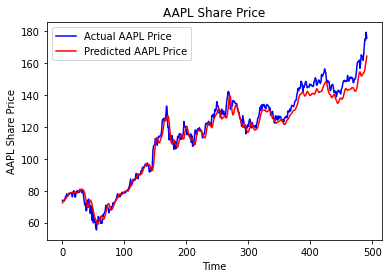

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader as web
import datetime as dt
import time

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM

# load data
start_time = time.time()
company = 'AAPL'
epochs = 115
batch_size = 64
units = 50
prediction_days = 60
start = dt.datetime(2012,1,1)
end = dt.datetime(2020,1,1)
test_start = dt.datetime(2020,1,1)
test_end = dt.datetime.now()


#################################################

data = web.DataReader(company, 'stooq', start, end)
data = data[::-1]

# prepare data for model
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1,1))



x_train = []
y_train = []

for x in range(prediction_days, len(scaled_data)):
    x_train.append(scaled_data[x-prediction_days:x, 0])
    y_train.append(scaled_data[x, 0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1)) #reshape (x_train, into.....)

# Build The Model
model = Sequential()

# 1 LSTM layer, 1 drop out layer,1 LSTM layer, 1 drop out layer, finally a dense layer
start_time = time.time()
model.add(LSTM(units=units, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(Dropout(0.2))
model.add(LSTM(units=units, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=units)) #no need to return anymore
model.add(Dropout(0.2))
model.add(Dense(units=1)) #prediction of the next closing value

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size) #epochs means the system see the data 24 times #batch_sizes mean the model see 32 data at once
time = ("%s" % (time.time() - start_time))

model.save('model1')
# ''' Test The Model Accuracy on Existing Data '''

# Load Test Data #use model that the program never see before


test_data = web.DataReader(company, 'stooq', test_start, test_end)
test_data = test_data[::-1]
actual_prices = test_data['Close'].values

total_dataset = pd.concat((data['Close'], test_data['Close']), axis=0)

model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values # what model is going to see
model_inputs = model_inputs.reshape(-1, 1)
model_inputs = scaler.transform(model_inputs)

# make predictions on test data

x_test = []

for x in range(prediction_days, len(model_inputs)): #+1 is the newest one
    x_test.append(model_inputs[x-prediction_days:x, 0])

x_test = np.array(x_test)
x_text = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

predicted_prices = model.predict(x_test)
predicted_prices = scaler.inverse_transform(predicted_prices)


# predict next stock market day

real_data = [model_inputs[len(model_inputs) - prediction_days:len(model_inputs + 1), 0]]
real_data = np.array(real_data)
real_data = np.reshape(real_data, (real_data.shape[0], real_data.shape[1], 1))

prediction = model.predict(real_data)
prediction = scaler.inverse_transform(prediction)
print(f'Prediction: {prediction}')
rmse = np.sqrt((np.mean(predicted_prices)-np.mean(actual_prices))**2)

#rmse = np.sqrt(np.mean(np.mean(predicted_prices-actual_prices)**2))
print(f'rms error: {rmse}')
print(f'time(secs): {time}')

# Plot the test Prediction

plt.plot(actual_prices, color='b', label=f'Actual {company} Price')
plt.plot(predicted_prices, color='r', label=f'Predicted {company} Price')
plt.title(f'{company} Share Price')
plt.xlabel('Time')
plt.ylabel(f'{company} Share Price')
plt.legend()
plt.savefig(f'company={company} units={units} epochs={epochs} batch_size={batch_size} tomorrow_prediction={prediction} rmse={rmse} prediction days={prediction_days} model training time(sec)={time}.png', dpi=1000)

Epoch 1/25
61/61 [==============================] - 11s 45ms/step - loss: 0.0600
Epoch 2/25
61/61 [==============================] - 3s 45ms/step - loss: 0.0076
Epoch 3/25
61/61 [==============================] - 3s 45ms/step - loss: 0.0067
Epoch 4/25
61/61 [==============================] - 3s 45ms/step - loss: 0.0068
Epoch 5/25
61/61 [==============================] - 3s 44ms/step - loss: 0.0062
Epoch 6/25
61/61 [==============================] - 3s 45ms/step - loss: 0.0059
Epoch 7/25
61/61 [==============================] - 3s 45ms/step - loss: 0.0052
Epoch 8/25
61/61 [==============================] - 3s 45ms/step - loss: 0.0054
Epoch 9/25
61/61 [==============================] - 3s 44ms/step - loss: 0.0055
Epoch 10/25
61/61 [==============================] - 3s 45ms/step - loss: 0.0050
Epoch 11/25
61/61 [==============================] - 3s 45ms/step - loss: 0.0048
Epoch 12/25
61/61 [==============================] - 3s 45ms/step - loss: 0.0045
Epoch 13/25
61/61 [=================

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


Prediction: [[72.408745]]
rms error: 10.605482076174852
time(secs): 77.57776236534119


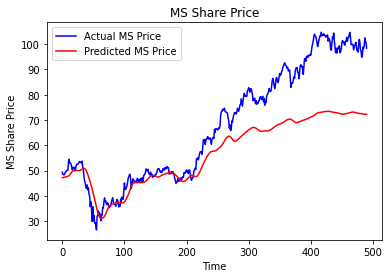

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader as web
import datetime as dt
import time

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM

# load data
start_time = time.time()
company = 'MS'
epochs = 25
batch_size = 32
units = 20
prediction_days = 60
start = dt.datetime(2012,1,1)
end = dt.datetime(2020,1,1)
test_start = dt.datetime(2020,1,1)
test_end = dt.datetime.now()


#################################################

data = web.DataReader(company, 'stooq', start, end)
data = data[::-1]

# prepare data for model
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1,1))



x_train = []
y_train = []

for x in range(prediction_days, len(scaled_data)):
    x_train.append(scaled_data[x-prediction_days:x, 0])
    y_train.append(scaled_data[x, 0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1)) #reshape (x_train, into.....)

# Build The Model
model = Sequential()

# 1 LSTM layer, 1 drop out layer,1 LSTM layer, 1 drop out layer, finally a dense layer
start_time = time.time()
model.add(LSTM(units=units, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(Dropout(0.2))
model.add(LSTM(units=units, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=units)) #no need to return anymore
model.add(Dropout(0.2))
model.add(Dense(units=1)) #prediction of the next closing value

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size) #epochs means the system see the data 24 times #batch_sizes mean the model see 32 data at once
time = ("%s" % (time.time() - start_time))

model.save('model1')
# ''' Test The Model Accuracy on Existing Data '''

# Load Test Data #use model that the program never see before


test_data = web.DataReader(company, 'stooq', test_start, test_end)
test_data = test_data[::-1]
actual_prices = test_data['Close'].values

total_dataset = pd.concat((data['Close'], test_data['Close']), axis=0)

model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values # what model is going to see
model_inputs = model_inputs.reshape(-1, 1)
model_inputs = scaler.transform(model_inputs)

# make predictions on test data

x_test = []

for x in range(prediction_days, len(model_inputs)): #+1 is the newest one
    x_test.append(model_inputs[x-prediction_days:x, 0])

x_test = np.array(x_test)
x_text = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

predicted_prices = model.predict(x_test)
predicted_prices = scaler.inverse_transform(predicted_prices)


# predict next stock market day

real_data = [model_inputs[len(model_inputs) - prediction_days:len(model_inputs + 1), 0]]
real_data = np.array(real_data)
real_data = np.reshape(real_data, (real_data.shape[0], real_data.shape[1], 1))

prediction = model.predict(real_data)
prediction = scaler.inverse_transform(prediction)
print(f'Prediction: {prediction}')
rmse = np.sqrt((np.mean(predicted_prices)-np.mean(actual_prices))**2)

#rmse = np.sqrt(np.mean(np.mean(predicted_prices-actual_prices)**2))
print(f'rms error: {rmse}')
print(f'time(secs): {time}')

# Plot the test Prediction

plt.plot(actual_prices, color='b', label=f'Actual {company} Price')
plt.plot(predicted_prices, color='r', label=f'Predicted {company} Price')
plt.title(f'{company} Share Price')
plt.xlabel('Time')
plt.ylabel(f'{company} Share Price')
plt.legend()
plt.savefig(f'company={company} units={units} epochs={epochs} batch_size={batch_size} tomorrow_prediction={prediction} rmse={rmse} prediction days={prediction_days} model training time(sec)={time}.png', dpi=1000)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
